In [1]:
### ARCHITECTURE SEARCH : averaging psychophysical results across architectures ###
import sys
import os
import json
import numpy as np
import glob
import copy
%matplotlib inline
import matplotlib.pyplot as plt

import importlib
import util_human_model_comparison
import util_figures_psychophysics
import util_figures


def load_results_dict(results_dict_fn, pop_key_list=['psychometric_function']):
    with open(results_dict_fn) as f: results_dict = json.load(f)
    for pop_key in pop_key_list:
        if pop_key in results_dict.keys():
            results_dict.pop(pop_key)
    return results_dict

def calc_best_metric(valid_metrics_fn, metric_key='f0_label:accuracy', maximize=True):
    with open(valid_metrics_fn) as f: valid_metrics_dict = json.load(f)
    metric_values = valid_metrics_dict[metric_key]
    if maximize: best_metric_value = np.max(metric_values)
    else: best_metric_value = np.min(metric_values)
    return best_metric_value


### Specify scope of all models to compare (regex must grab all model output directories)
# regex_model_dir = '/om/scratch/*/msaddler/pitchnet/saved_models/arch_search_v01/arch_*/'
# regex_model_dir = '/nobackup/scratch/*/msaddler/pitchnet/saved_models/arch_search_v01/arch_*/'
regex_model_dir = '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/'
# regex_model_dir = '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_pos10pos30_AN_BW10eN1_IHC3000Hz_classification*/'
# regex_model_dir = '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_posInf_AN_BW10eN1_IHC3000Hz_classification*/'
# regex_model_dir = '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_filter_signalBPv00_AN_BW10eN1_IHC3000Hz_classification*/'
# regex_model_dir = '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_filter_signalHPv00_AN_BW10eN1_IHC3000Hz_classification*/'
# regex_model_dir = '/saved_models/models_sr20000/arch_0302/PND_synthetic_noise_UMNm_snr_neg10pos10_phase0_filter_signalLPv00_AN_BW10eN1_IHC3000Hz_classification*/'
# regex_model_dir = '/saved_models/models_sr20000/arch_0302/PND_synthetic_noise_UMNm_snr_neg10pos10_phase0_filter_signalBPv00_AN_BW10eN1_IHC3000Hz_classification*/'
# regex_model_dir = '/saved_models/models_sr20000/arch_0302/PND_synthetic_noise_UMNm_snr_neg10pos10_phase0_filter_signalHPv00_AN_BW10eN1_IHC3000Hz_classification*/'
# regex_model_dir = '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_spont1eN1_BW10eN1_IHC3000Hz_classification*/'
# regex_model_dir = '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_filter_signalBPv01_AN_BW10eN1_IHC3000Hz_classification*/'
# regex_model_dir = '/saved_models/models_sr20000/arch_0302/PND_v08spch_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/'
# regex_model_dir = '/saved_models/models_sr20000/arch_0302/PND_v08inst_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/'
# regex_model_dir = '/saved_models/models_sr20000/arch_0302/PND_synthetic_noise_UMNm_snr_neg10pos10_phase01_filter_signalLPv00_AN_BW10eN1_IHC3000Hz_classification*/'
# regex_model_dir = '/saved_models/models_sr20000/arch_0302/PND_synthetic_noise_UMNm_snr_neg10pos10_phase01_filter_signalBPv00_AN_BW10eN1_IHC3000Hz_classification*/'
# regex_model_dir = '/saved_models/models_sr20000/arch_0302/PND_synthetic_noise_UMNm_snr_neg10pos10_phase01_filter_signalHPv00_AN_BW10eN1_IHC3000Hz_classification*/'

# regex_model_dir = '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW05eN1_IHC3000Hz_classification*/'
# regex_model_dir = '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW20eN1_IHC3000Hz_classification*/'
# regex_model_dir = '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC9000Hz_classification*/'
# regex_model_dir = '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC6000Hz_classification*/'
# regex_model_dir = '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC1000Hz_classification*/'
# regex_model_dir = '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC0250Hz_classification*/'
# regex_model_dir = '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC0050Hz_classification*/'

basename_valid_metrics = 'validation_metrics.json'
basename_arch_config = 'brain_arch.json'

### Specify results_dict basenames for each experiment
experiment_to_basename_map = {
    'bernox2005': 'EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json',
    'transposedtones': 'EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json',
    'freqshiftedcomplexes': 'EVAL_mooremoore2003_080to480Hz_bestckpt_results_dict.json',
    'mistunedharmonics': 'EVAL_MistunedHarm_v00_bestckpt_results_dict.json',
    'altphasecomplexes': 'EVAL_AltPhase_v01_bestckpt_results_dict.json',
}
for key in experiment_to_basename_map.keys():
    experiment_to_basename_map[key] = experiment_to_basename_map[key].replace('EVAL_', 'EVAL_SOFTMAX_')

experiment_keys = [
    'bernox2005',
    'transposedtones',
    'freqshiftedcomplexes',
    'mistunedharmonics',
    'altphasecomplexes'
]
list_valid_metric = []
list_model_dir = []
disp_step = 100

for idx, model_dir in enumerate(sorted(glob.glob(regex_model_dir))):
    fn_valid_metric = os.path.join(model_dir, basename_valid_metrics)
    fn_arch_config = os.path.join(model_dir, basename_arch_config)
    fn_result_dict = {}
    for ek in experiment_keys:
        fn_result_dict[ek] = os.path.join(model_dir, experiment_to_basename_map[ek])
    
    include_model_flag = True
    if not os.path.exists(fn_arch_config): include_model_flag = False
    if not os.path.exists(fn_valid_metric): include_model_flag = False
    for ek in experiment_keys:
        if not os.path.exists(fn_result_dict[ek]): include_model_flag = False 
    
    if include_model_flag:
        list_model_dir.append(model_dir)
        list_valid_metric.append(calc_best_metric(fn_valid_metric))
    
    if idx % disp_step == 0:
        print(model_dir, include_model_flag)

print('Number of included networks:', len(list_valid_metric))


/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification0/ True
Number of included networks: 3


In [42]:
importlib.reload(util_figures)
importlib.reload(util_figures_psychophysics)
importlib.reload(util_human_model_comparison)

sort_idx = np.flip(np.argsort(list_valid_metric))
sorted_list_valid_metric = np.array(list_valid_metric)[sort_idx]
sorted_list_model_dir = np.array(list_model_dir)[sort_idx]
top_model_dirs = sorted_list_model_dir[:]
# idxxx = 352
# top_model_dirs = sorted_list_model_dir[idxxx:idxxx+40]
print(len(top_model_dirs))

experiment_to_plot_fcn_map = {
    'bernox2005': util_figures_psychophysics.make_bernox_threshold_plot,
    'transposedtones': util_figures_psychophysics.make_TT_threshold_plot,
    'freqshiftedcomplexes': util_figures_psychophysics.make_freqshiftedcomplexes_plot,
    'mistunedharmonics': util_figures_psychophysics.make_mistuned_harmonics_bar_graph,
    'altphasecomplexes': util_figures_psychophysics.make_altphase_histogram_plot,
}

top_model_results_dicts = {key: [] for key in experiment_keys}
for key in experiment_keys:
    for model_dir in top_model_dirs:
        results_dict_fn = os.path.join(model_dir, experiment_to_basename_map[key])
        with open(results_dict_fn) as f:
            top_model_results_dicts[key].append(json.load(f))

results_dicts = top_model_results_dicts

3


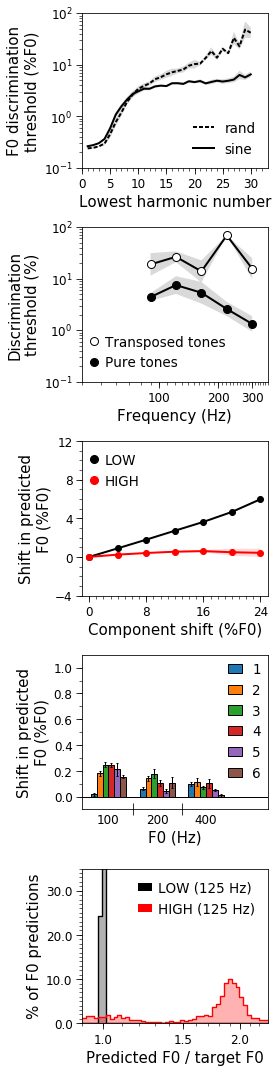

/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_02_03_pitchnet_paper_figures/all_psychophysics___PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification.pdf


In [51]:
NROWS = len(experiment_keys)
NCOLS = 1
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(4*NCOLS, 3*NROWS))

experiment_to_human_results_map = {
    'bernox2005': util_human_model_comparison.get_human_results_dict_bernox2005(),
    'transposedtones': util_human_model_comparison.get_human_results_dict_transposedtones(),
    'freqshiftedcomplexes': util_human_model_comparison.get_human_results_dict_freqshiftedcomplexes(),
    'mistunedharmonics': util_human_model_comparison.get_human_results_dict_mistunedharmonics(),
    'altphasecomplexes': util_human_model_comparison.get_human_results_dict_altphasecomplexes(),
}

for ax_idx, key in enumerate(experiment_keys):
    plot_fcn = experiment_to_plot_fcn_map[key]
    kwargs = {
        'include_yerr': True,
#         'kwargs_bootstrap': {
#             'bootstrap_repeats': 10000,
#             'metric_function': 'mean',
#         },
        'kwargs_bootstrap': {},
        'fontsize_labels': 15,
        'fontsize_legend': 13.5,
    }
    if ('bernox' in key) or ('transposed' in key):
        kwargs['threshold_cap'] = 100
    if ('freqshifted' in key) or ('mistuned' in key):
        kwargs['use_relative_shift'] = True
    plot_fcn(ax[ax_idx], results_dicts[key], **kwargs)
#     plot_fcn(ax[ax_idx], experiment_to_human_results_map[key], **kwargs)

plt.tight_layout()
plt.show()

model_name = regex_model_dir
model_name = model_name.replace('/saved_models/models_sr20000/arch_0302/', '')
model_name = model_name.replace('*/', '')
# # model_name = 'arch_search_v01_rank_{:03}to{:03}'.format(idxxx, idxxx+40)
# # model_name = 'HUMANS'
save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_02_03_pitchnet_paper_figures/'
save_fn = os.path.join(save_dir, 'all_psychophysics___{}.pdf')
save_fn = save_fn.format(model_name)
# fig.savefig(save_fn, bbox_inches='tight')
print(save_fn)


In [ ]:
importlib.reload(util_figures_psychophysics)
importlib.reload(util_human_model_comparison)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,3))
_ = util_figures_psychophysics.make_altphase_histogram_plot(ax, experiment_to_human_results_map['altphasecomplexes'])
plt.show()



# fig, ax = util_figures_psychophysics.make_altphase_histograms(top_model_results_dicts['altphasecomplexes'])
# plt.show()


In [33]:
### GENERIC PARAMETERS
figsize=(4,3)
poster_plot_kwargs = {
    'fontsize_labels': 16,
    'fontsize_legend': 14,
    'fontsize_ticks': 14,
    'include_yerr': True,
    'kwargs_bootstrap': {
        'bootstrap_repeats': 1000,
        'metric_function': 'median',
    },
}

### Build dictionary of human results_dict for each experiment
experiment_to_human_results_map = {
    'bernox2005': util_human_model_comparison.get_human_results_dict_bernox2005(),
    'transposedtones': util_human_model_comparison.get_human_results_dict_transposedtones(),
    'freqshiftedcomplexes': util_human_model_comparison.get_human_results_dict_freqshiftedcomplexes(),
    'mistunedharmonics': util_human_model_comparison.get_human_results_dict_mistunedharmonics(),
    'altphasecomplexes': util_human_model_comparison.get_human_results_dict_altphasecomplexes(),
}


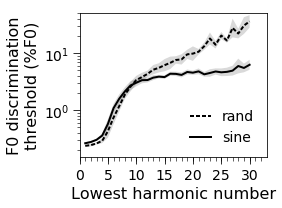

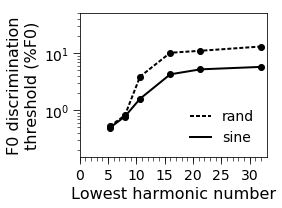

In [38]:
### bernox2005 discrimination threholds

importlib.reload(util_figures_psychophysics)
importlib.reload(util_human_model_comparison)
plot_fcn = util_figures_psychophysics.make_bernox_threshold_plot
human_rd = util_human_model_comparison.get_human_results_dict_bernox2005()

kwargs = copy.deepcopy(poster_plot_kwargs)
kwargs['xlimits'] = [0, 33]
kwargs['ylimits'] = [0.15, 50]
kwargs['threshold_cap'] = 50

# PLOT MODEL
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
plot_fcn(ax, results_dicts['bernox2005'], **kwargs)
plt.tight_layout()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_11_07_manipulating_bez2018model/'
# save_fn = os.path.join(save_dir, 'arch0628_spike_counts_npc20_bernox_threshold_plot.pdf')
# fig.savefig(save_fn, bbox_inches='tight')


# PLOT HUMAN
sine_plot_kwargs={'marker': '.', 'ms':12}
rand_plot_kwargs={'marker': '.', 'ms':12}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
plot_fcn(ax, human_rd, **kwargs,
         sine_plot_kwargs=sine_plot_kwargs,
         rand_plot_kwargs=rand_plot_kwargs)
plt.tight_layout()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_10_17_APAN_poster/'
# save_fn = os.path.join(save_dir, 'human_bernox_threshold_plot.pdf')
# fig.savefig(save_fn, bbox_inches='tight')

plt.show()

In [ ]:
### transposed tones discrimination thresholds

importlib.reload(util_figures_psychophysics)
importlib.reload(util_human_model_comparison)
plot_fcn = util_figures_psychophysics.make_TT_threshold_plot
human_rd = util_human_model_comparison.get_human_results_dict_transposedtones()

kwargs = copy.deepcopy(poster_plot_kwargs)
kwargs['fontsize_legend'] = 11
kwargs['xlimits'] = [40, 360]
kwargs['ylimits'] = [0.15, 50]
kwargs['threshold_cap'] = 50

# PLOT MODEL
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
plot_fcn(ax, results_dicts['transposedtones'], **kwargs)
plt.tight_layout()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_11_07_manipulating_bez2018model/'
# save_fn = os.path.join(save_dir, 'arch0628_spike_counts_npc20_transposedtones_threshold_plot.pdf')
# fig.savefig(save_fn, bbox_inches='tight')

# PLOT HUMAN
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
plot_fcn(ax, human_rd, **kwargs)
plt.tight_layout()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_10_17_APAN_poster/'
# save_fn = os.path.join(save_dir, 'human_transposedtones_threshold_plot.pdf')
# fig.savefig(save_fn, bbox_inches='tight')

plt.show()

In [ ]:
### frequency shifted complexes

importlib.reload(util_figures_psychophysics)
importlib.reload(util_human_model_comparison)
plot_fcn = util_figures_psychophysics.make_freqshiftedcomplexes_plot
human_rd = util_human_model_comparison.get_human_results_dict_freqshiftedcomplexes()

kwargs = copy.deepcopy(poster_plot_kwargs)
kwargs['restrict_conditions'] = ['5', '11', '16']
# kwargs['cmap_name'] = ['r', 'b', 'k']#'Dark2'

# PLOT MODEL
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
plot_fcn(ax, results_dicts['freqshiftedcomplexes'], **kwargs, use_relative_shift=True)
plt.tight_layout()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_11_07_manipulating_bez2018model/'
# save_fn = os.path.join(save_dir, 'arch0628_spike_counts_npc20_freqshift_plot.pdf')
# fig.savefig(save_fn, bbox_inches='tight')

# PLOT HUMAN
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
plot_fcn(ax, human_rd, **kwargs, use_relative_shift=True)
plt.tight_layout()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_10_17_APAN_poster/'
# save_fn = os.path.join(save_dir, 'human_freqshift_plot.pdf')
# fig.savefig(save_fn, bbox_inches='tight')

plt.show()

In [ ]:
### mistuned harmonics bar graph

importlib.reload(util_figures_psychophysics)
importlib.reload(util_human_model_comparison)
plot_fcn = util_figures_psychophysics.make_mistuned_harmonics_bar_graph
human_rd = util_human_model_comparison.get_human_results_dict_mistunedharmonics()

kwargs = copy.deepcopy(poster_plot_kwargs)
kwargs['cmap_name'] = 'tab10'

# PLOT MODEL
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
plot_fcn(ax, results_dicts['mistunedharmonics'], **kwargs, use_relative_shift=True)
plt.tight_layout()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_11_07_manipulating_bez2018model/'
# save_fn = os.path.join(save_dir, 'arch0628_spike_counts_npc20_mistunedharm_bar_plot.pdf')
# fig.savefig(save_fn, bbox_inches='tight')

# PLOT HUMAN
kwargs_human = copy.deepcopy(kwargs)
kwargs_human['include_yerr'] = False
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
plot_fcn(ax, human_rd, **kwargs_human, use_relative_shift=True)
plt.tight_layout()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_10_17_APAN_poster/'
# save_fn = os.path.join(save_dir, 'human_mistunedharm_bar_plot.pdf')
# fig.savefig(save_fn, bbox_inches='tight')

plt.show()

In [ ]:
### mistuned harmonics line plot

importlib.reload(util_figures_psychophysics)
importlib.reload(util_human_model_comparison)
plot_fcn = util_figures_psychophysics.make_mistuned_harmonics_line_plot
human_rd = util_human_model_comparison.get_human_results_dict_mistunedharmonics()

kwargs = copy.deepcopy(poster_plot_kwargs)
# kwargs['cmap_name'] = 'Accent'
kwargs['ylimits'] = [-0.1, 0.4]
kwargs['yticks'] = 0.2

# PLOT MODEL
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
plot_fcn(ax, results_dicts['mistunedharmonics'], **kwargs, use_relative_shift=True)
plt.tight_layout()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_11_07_manipulating_bez2018model/'
# save_fn = os.path.join(save_dir, 'arch0628_spike_counts_npc20_mistunedharm_line200Hz_plot.pdf')
# fig.savefig(save_fn, bbox_inches='tight')


plt.show()

In [ ]:
### alt phase line plot

importlib.reload(util_figures_psychophysics)
importlib.reload(util_human_model_comparison)
plot_fcn = util_figures_psychophysics.make_altphase_line_plot
human_rd = util_human_model_comparison.get_human_results_dict_altphasecomplexes(average_conditions=False)

kwargs = copy.deepcopy(poster_plot_kwargs)
kwargs['fontsize_legend'] = 13

# PLOT MODEL
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
plot_fcn(ax, results_dicts['altphasecomplexes'], **kwargs)
plt.tight_layout()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_11_07_manipulating_bez2018model/'
# save_fn = os.path.join(save_dir, 'arch0628_spike_counts_npc20_altphase_line_plot.pdf')
# fig.savefig(save_fn, bbox_inches='tight')

# PLOT HUMAN
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
plot_fcn(ax, human_rd, **kwargs)
plt.tight_layout()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_10_17_APAN_poster/'
# save_fn = os.path.join(save_dir, 'human_altphase_line_plot.pdf')
# fig.savefig(save_fn, bbox_inches='tight')

plt.show()

In [ ]:
### altphase histograms

importlib.reload(util_figures_psychophysics)
importlib.reload(util_human_model_comparison)

# PLOT MODEL
fig, ax = util_figures_psychophysics.make_altphase_histograms(results_dicts['altphasecomplexes'],
                                                              bin_step=0.01,
                                                              figsize=(8,5),
                                                              fontsize_labels=18,
                                                              fontsize_legend=16,
                                                              fontsize_ticks=14,
                                                              xticks=[1.0, 1.5, 2.0],
                                                              xlimits=[0.9, 2.3],
                                                              yticks=5,
                                                              ylimits=[0, 25],
                                                              condition_plot_labels={})

plt.show()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_11_07_manipulating_bez2018model/'
# save_fn = os.path.join(save_dir, 'arch0628_spike_counts_npc20_altphase_histogram_plot.pdf')
# fig.savefig(save_fn, bbox_inches='tight')


In [ ]:
import sys
import os
import json
import numpy as np
import glob
import copy
import importlib
%matplotlib inline
import matplotlib.pyplot as plt

import util_human_model_comparison
import util_figures_psychophysics
importlib.reload(util_figures_psychophysics)


### SPECIFY THE OUTERMOST DIRECTORY CONTAINING ALL MODELS
model_dir = '/om2/user/msaddler/pitchnet/saved_models/'

### SPECIFY RESULTS DICT BASENAME: determines which experiment to plot
# results_dict_basename = 'EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json'
# results_dict_basename = 'EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json'
# results_dict_basename = 'EVAL_mooremoore2003_080to480Hz_bestckpt_results_dict.json'
# results_dict_basename = 'EVAL_MistunedHarm_v00_bestckpt_results_dict.json'
# results_dict_basename = 'EVAL_AltPhase_v01_bestckpt_results_dict.json'
results_dict_basename = 'EVAL_SOFTMAX_bernox2005_FixedFilter_bestckpt_results_dict.json'
# results_dict_basename = 'EVAL_SOFTMAX_oxenham2004_080to320Hz_bestckpt_results_dict.json'
# results_dict_basename = 'EVAL_SOFTMAX_mooremoore2003_080to480Hz_bestckpt_results_dict.json'
# results_dict_basename = 'EVAL_SOFTMAX_MistunedHarm_v00_bestckpt_results_dict.json'
# results_dict_basename = 'EVAL_SOFTMAX_AltPhase_v01_bestckpt_results_dict.json'


### SPECIFY REGULAR EXPRESSIONS FOR MODELS: (regex, model_name) pairs
master_list = [
#     ('models_sr20000/arch_0302/PND_v08spch_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/', 'Speech only'),
#     ('models_sr20000/arch_0302/PND_v08inst_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/', 'Instruments only'),

#     ('models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW05eN1_IHC3000Hz_classification*/', '0.5x Tr'),
#     ('models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/', '1.0x Tr'),
#     ('models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW20eN1_IHC3000Hz_classification*/', '2.0x Tr'),
#     ('models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW30eN1_IHC3000Hz_classification*/', '3.0x Tr'),

#     ('models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/EVAL_SOFTMAX_test_AN_BW05eN1_bernox2005_FixedFilter_bestckpt_results_dict.json', '0.5x Te'),
#     ('models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/EVAL_SOFTMAX_bernox2005_FixedFilter_bestckpt_results_dict.json', '1.0x Te'),
#     ('models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/EVAL_SOFTMAX_test_AN_BW20eN1_bernox2005_FixedFilter_bestckpt_results_dict.json', '2.0x Te'),
#     ('models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/EVAL_SOFTMAX_test_AN_BW30eN1_bernox2005_FixedFilter_bestckpt_results_dict.json', '3.0x Te'),

#     ('models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/', 'PND_v08_snr[-10,+10]'),
#     ('models_sr20000/arch_0302/PND_v08_TLAS_snr_pos10pos30_AN_BW10eN1_IHC3000Hz_classification*/', 'PND_v08_snr[+10,+30]'),

#     ('models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/', 'PND_v08'),
#     ('models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_filter_signalHPv00_AN_BW10eN1_IHC3000Hz_classification*/', 'PND_v08_HPv00'),
#     ('models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_filter_signalBPv00_AN_BW10eN1_IHC3000Hz_classification*/', 'PND_v08_BPv00'),
#     ('models_sr20000/arch_0302/PND_synthetic_noise_UMNm_snr_neg10pos10_phase0_filter_signalLPv00_AN_BW10eN1_IHC3000Hz_classification*/', 'synth_LPv00'),
#     ('models_sr20000/arch_0302/PND_synthetic_noise_UMNm_snr_neg10pos10_phase0_filter_signalHPv00_AN_BW10eN1_IHC3000Hz_classification*/', 'synth_HPv00'),
#     ('models_sr20000/arch_0302/PND_synthetic_noise_UMNm_snr_neg10pos10_phase0_filter_signalBPv00_AN_BW10eN1_IHC3000Hz_classification*/', 'synth_BPv00'),
    
    ('models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC0050Hz_classification*/', '0050Hz'),
    ('models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC0250Hz_classification*/', '0250Hz'),
    ('models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC1000Hz_classification*/', '1000Hz'),
    ('models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/', '3000Hz'),
#     ('models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC6000Hz_classification*/', '6000Hz'),
#     ('models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC9000Hz_classification*/', '9000Hz'),
    
#     ('PND_v04_TLAS_AN_BW10eN1_IHC3000Hz_classification*/EVAL_SOFTMAX_TEST_BW05eN1_IHC3000Hz_bernox2005_FixedFilter_bestckpt_results_dict.json', '0.50x'),
#     ('PND_v04_TLAS_AN_BW10eN1_IHC3000Hz_classification*/', '1.00x'),
#     ('PND_v04_TLAS_AN_BW10eN1_IHC3000Hz_classification*/EVAL_SOFTMAX_TEST_BW15eN1_IHC3000Hz_bernox2005_FixedFilter_bestckpt_results_dict.json', '1.50x'),
#     ('PND_v04_TLAS_AN_BW10eN1_IHC3000Hz_classification*/EVAL_SOFTMAX_TEST_BW20eN1_IHC3000Hz_bernox2005_FixedFilter_bestckpt_results_dict.json', '2.00x'),
#     ('PND_v04_TLAS_AN_BW10eN1_IHC3000Hz_classification*/EVAL_SOFTMAX_TEST_BW25eN1_IHC3000Hz_bernox2005_FixedFilter_bestckpt_results_dict.json', '2.50x'),

#     ('PND_v04_TLAS_AN_BW05eN1_IHC3000Hz_classification*/', '0.50x'),
#     ('PND_v04_TLAS_AN_BW10eN1_IHC3000Hz_classification*/', '1.00x'),
#     ('PND_v04_TLAS_AN_BW15eN1_IHC3000Hz_classification*/', '1.50x'),
#     ('PND_v04_TLAS_AN_BW20eN1_IHC3000Hz_classification*/', '2.00x'),
#     ('PND_v04_TLAS_AN_BW25eN1_IHC3000Hz_classification*/', '2.50x'),
    
#     ('arch_0628/PND_v04_TLAS_AN_BW10eN1_IHC3000Hz_classification*/EVAL_SOFTMAX_TEST_BW05eN1_IHC3000Hz_bernox2005_FixedFilter_bestckpt_results_dict.json', '0.50x'),
#     ('arch_0628/PND_v04_TLAS_AN_BW10eN1_IHC3000Hz_classification*/', '1.00x'),
#     ('arch_0628/PND_v04_TLAS_AN_BW10eN1_IHC3000Hz_classification*/EVAL_SOFTMAX_TEST_BW15eN1_IHC3000Hz_bernox2005_FixedFilter_bestckpt_results_dict.json', '1.50x'),
#     ('arch_0628/PND_v04_TLAS_AN_BW10eN1_IHC3000Hz_classification*/EVAL_SOFTMAX_TEST_BW20eN1_IHC3000Hz_bernox2005_FixedFilter_bestckpt_results_dict.json', '2.00x'),
#     ('arch_0628/PND_v04_TLAS_AN_BW10eN1_IHC3000Hz_classification*/EVAL_SOFTMAX_TEST_BW25eN1_IHC3000Hz_bernox2005_FixedFilter_bestckpt_results_dict.json', '2.50x'),
 
#     ('arch_0628/PND_v04_TLAS_AN_BW05eN1_IHC3000Hz_classification*/', '0.50x'),
#     ('arch_0628/PND_v04_TLAS_AN_BW10eN1_IHC3000Hz_classification*/', '1.00x'),
#     ('arch_0628/PND_v04_TLAS_AN_BW15eN1_IHC3000Hz_classification*/', '1.50x'),
#     ('arch_0628/PND_v04_TLAS_AN_BW20eN1_IHC3000Hz_classification*/', '2.00x'),
#     ('arch_0628/PND_v04_TLAS_AN_BW25eN1_IHC3000Hz_classification*/', '2.50x'),

#     ('models_sr20000/arch_0628mod/PND_v04_TLAS_AN_BW10eN1_IHC3000Hz_classification*/', 'PND_v04_sr20000'),
#     ('models_sr20000/arch_0628mod/PND_v07_TLAS_AN_BW10eN1_IHC3000Hz_classification*/', 'PND_v07_sr20000'),

#     ('models_sr16000/arch_0628mod/PND_v04_TLAS_AN_BW10eN1_IHC3000Hz_classification*/', '3000Hz, sr16kHz'),
#     ('models_sr16000/arch_0628mod/PND_v04_TLAS_AN_BW10eN1_IHC4000Hz_classification*/', '4000Hz'),
#     ('models_sr16000/arch_0628mod/PND_v04_TLAS_AN_BW10eN1_IHC5000Hz_classification*/', '5000Hz'),
#     ('models_sr16000/arch_0628mod/PND_v04_TLAS_AN_BW10eN1_IHC7000Hz_classification*/', '7000Hz'),
    
#     ('arch_0628/models_spike_counts/PND_v04_TLAS_AN_BW10eN1_IHC0050Hz_classification*/', '50Hz'),
#     ('arch_0628/models_spike_counts/PND_v04_TLAS_AN_BW10eN1_IHC0250Hz_classification*/', '250Hz'),
#     ('arch_0628/models_spike_counts/PND_v04_TLAS_AN_BW10eN1_IHC0500Hz_classification*/', '500Hz'),
#     ('arch_0628/models_spike_counts/PND_v04_TLAS_AN_BW10eN1_IHC1000Hz_classification*/', '1000Hz'),
#     ('arch_0628/models_spike_counts/PND_v04_TLAS_AN_BW10eN1_IHC3000Hz_classification*/', '3000Hz'),
#     ('arch_0628/models_spike_counts/PND_v04_TLAS_AN_BW10eN1_IHC4000Hz_classification*/', '4000Hz'),
#     ('arch_0628/models_spike_counts/PND_v04_TLAS_AN_BW10eN1_IHC5000Hz_classification*/', '5000Hz'),
    
#     ('arch_0628/PND_v04_TLAS_AN_BW10eN1_IHC0050Hz_classification*/', '50Hz'),
#     ('arch_0628/PND_v04_TLAS_AN_BW10eN1_IHC0250Hz_classification*/', '250Hz'),
#     ('arch_0628/PND_v04_TLAS_AN_BW10eN1_IHC0500Hz_classification*/', '500Hz'),
#     ('arch_0628/PND_v04_TLAS_AN_BW10eN1_IHC1000Hz_classification*/', '1000Hz'),
#     ('arch_0628/PND_v04_TLAS_AN_BW10eN1_IHC3000Hz_classification*/', '3000Hz, sr10kHz'),
#     ('arch_0628/PND_v04_TLAS_AN_BW10eN1_IHC4000Hz_classification*/', '4000Hz'),
#     ('arch_0628/PND_v04_TLAS_AN_BW10eN1_IHC5000Hz_classification*/', '5000Hz'),
    
#     ('arch_0628/PND_v04_TLAS_classification*/', 'arch_0628_PND_v04_TLAS'),
#     ('arch_0628/PND_v05_TLAS_classification*/', 'Speech only (OLD!!)'),
#     ('arch_0628/PND_v06_TLAS_classification*/', 'Instruments only (OLD!!)'),
#     ('arch_0628/PND_v04_JWSS_highpass_v00_classification*/', 'arch_0628_PND_v04_JWSS_highpass_v00'),
#     ('arch_0628/PND_v04_JWSS_highSNR_classification*/', 'arch_0628_PND_v04_JWSS_highSNR'),
#     ('arch_0628/PND_v04_TLAS_halflowpassnoise_v02_classification*/', 'arch_0628_PND_v04_TLAS_hlpn'),
    
#     ('models_RSB/arch_0628/PND_v04_TLAS_halflowpassnoise_v02_rsb0pt5xBW_classification*/', '0.50x'),
#     ('models_RSB/arch_0628/PND_v04_TLAS_halflowpassnoise_v02_classification*/', '1.00x'),
#     ('models_RSB/arch_0628/PND_v04_TLAS_halflowpassnoise_v02_rsb1pt5xBW_classification*/', '1.50x'),
#     ('models_RSB/arch_0628/PND_v04_TLAS_halflowpassnoise_v02_rsb2pt0xBW_classification*/', '2.00x'),
#     ('models_RSB/arch_0628/PND_v04_TLAS_halflowpassnoise_v02_rsb2pt5xBW_classification*/', '2.50x'),
    
#     ('models_RSB/arch_0628/PND_v04_TLAS_halflowpassnoise_v02_classification*/EVAL_SOFTMAX_bernox2005_FixedFilter_bestckpt_TEST_rsb0pt5xBW_results_dict.json', '0.50x'),
#     ('models_RSB/arch_0628/PND_v04_TLAS_halflowpassnoise_v02_classification*/', '1.00x'),
#     ('models_RSB/arch_0628/PND_v04_TLAS_halflowpassnoise_v02_classification*/EVAL_SOFTMAX_bernox2005_FixedFilter_bestckpt_TEST_rsb1pt5xBW_results_dict.json', '1.50x'),
#     ('models_RSB/arch_0628/PND_v04_TLAS_halflowpassnoise_v02_classification*/EVAL_SOFTMAX_bernox2005_FixedFilter_bestckpt_TEST_rsb2pt0xBW_results_dict.json', '2.00x'),
#     ('models_RSB/arch_0628/PND_v04_TLAS_halflowpassnoise_v02_classification*/EVAL_SOFTMAX_bernox2005_FixedFilter_bestckpt_TEST_rsb2pt5xBW_results_dict.json', '2.50x'),

#     ('models_RSB/arch_0628/PND_v04_TLAS_classification*/EVAL_SOFTMAX_TEST_rsb0pt5xBW_bernox2005_FixedFilter_bestckpt_results_dict.json', '0.50x'),
#     ('models_RSB/arch_0628/PND_v04_TLAS_classification*/', '1.00x'),
#     ('models_RSB/arch_0628/PND_v04_TLAS_classification*/EVAL_SOFTMAX_TEST_rsb1pt5xBW_bernox2005_FixedFilter_bestckpt_results_dict.json', '1.50x'),
#     ('models_RSB/arch_0628/PND_v04_TLAS_classification*/EVAL_SOFTMAX_TEST_rsb2pt0xBW_bernox2005_FixedFilter_bestckpt_results_dict.json', '2.00x'),
    
#     ('models_RSB/arch_0628/PND_v04_TLAS_rsb0pt5xBW_classification*/', '0.50x'),
#     ('models_RSB/arch_0628/PND_v04_TLAS_classification*/', '1.00x'),
#     ('models_RSB/arch_0628/PND_v04_TLAS_rsb1pt5xBW_classification*/', '1.50x'),
#     ('models_RSB/arch_0628/PND_v04_TLAS_rsb2pt0xBW_classification*/', '2.00x'),
    
#     ('arch_0628/PND_v04_TLAS_classification*/', 'None'),
#     ('arch_0628/PND_v04_TLAS_ANlowpass1000Hz_classification*/', '1kHz'),
#     ('arch_0628/PND_v04_TLAS_ANlowpass0640Hz_classification*/', '640Hz'),
#     ('arch_0628/PND_v04_TLAS_ANlowpass0320Hz_classification*/', '320Hz'),
#     ('arch_0628/PND_v04_TLAS_ANlowpass0050Hz_classification*/', '50Hz'),
    
#     ('PND_v04_JWSS_classification*/', '~5kHz'),
#     ('PND_v04_JWSS_ANlowpass1000Hz_classification*/', '1kHz'),
#     ('PND_v04_JWSS_ANlowpass0320Hz_classification*/', '320Hz'),
#     ('PND_v04_JWSS_ANlowpass0050Hz_classification*/', '50Hz'),
#     ('arch_0628/PND_v04_JWSS_classification*/', '5000Hz'),
#     ('arch_0628/PND_v04_JWSS_ANlowpass1000Hz_classification*/', '1000Hz'),
#     ('arch_0628/PND_v04_JWSS_ANlowpass0320Hz_classification*/', '320Hz'),
#     ('arch_0628/PND_v04_JWSS_ANlowpass0050Hz_classification*/', '50Hz'),

]

### LOAD PSYCHOPHYSICS EXPERIMENT RESULTS
model_keys = []
results_dicts = {}
master_count = 0
for fn_regex, model_key in master_list:
    results_dicts[model_key] = []
    model_keys.append(model_key)
    if not fn_regex[0] == '/': fn_regex = os.path.join(model_dir, fn_regex)
    if '.json' not in fn_regex: fn_regex = os.path.join(fn_regex, results_dict_basename)
    for results_dict_fn in sorted(glob.glob(fn_regex)):
        master_count = master_count + 1
        with open(results_dict_fn) as f:
            results_dicts[model_key].append(json.load(f))

print('Loaded results from {} files ({})'.format(master_count, results_dict_basename))
for key in results_dicts.keys():
    print(key, len(results_dicts[key]))


In [ ]:
### GENERIC PARAMETERS
figsize=(4,3)
poster_plot_kwargs = {
    'fontsize_labels': 16,
    'fontsize_legend': 14,
    'fontsize_ticks': 15,
    'include_yerr': True,
    'kwargs_bootstrap': {
        'bootstrap_repeats': 1000,
        'metric_function': 'median',
    },
}

### Build dictionary of human results_dict for each experiment
experiment_to_human_results_map = {
    'bernox2005': util_human_model_comparison.get_human_results_dict_bernox2005(),
    'transposedtones': util_human_model_comparison.get_human_results_dict_transposedtones(),
    'freqshiftedcomplexes': util_human_model_comparison.get_human_results_dict_freqshiftedcomplexes(),
    'mistunedharmonics': util_human_model_comparison.get_human_results_dict_mistunedharmonics(),
    'altphasecomplexes': util_human_model_comparison.get_human_results_dict_altphasecomplexes(),
}

In [ ]:
### bernox2005 discrimination threholds

importlib.reload(util_figures_psychophysics)
importlib.reload(util_human_model_comparison)
plot_fcn = util_figures_psychophysics.make_bernox_threshold_plot
human_rd = util_human_model_comparison.get_human_results_dict_bernox2005()

kwargs = copy.deepcopy(poster_plot_kwargs)
kwargs['xlimits'] = [0, 33]
kwargs['ylimits'] = [1e-1, 1e2]
kwargs['threshold_cap'] = 1e2

kwargs['legend_on'] = True
kwargs['include_yerr'] = True
kwargs['restrict_conditions'] = [0]
kwargs['legend_kwargs'] = {'ncol':2,
                           'handlelength':0.5,
#                            'bbox_to_anchor':[1.04, -0.04],
                           'loc': 'best',
                           'handletextpad':0.4,
                          }
kwargs['fontsize_legend'] = 11

COLOR_LIST = util_figures_psychophysics.get_color_list(10, cmap_name='tab10')


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)

### PLOT MODEL ###
for cidx, key in enumerate(model_keys):
    kwargs['sine_plot_kwargs'] = {
        'label': key,
        'color': COLOR_LIST[cidx],
        'lw':3
    }
    kwargs['rand_plot_kwargs'] = {
        'label': None,
        'color': COLOR_LIST[cidx],
        'lw':3
    }
#     if key == 'None' or key == '3000Hz' or key == '1.00x': kwargs['sine_plot_kwargs']['color'] = 'k'
    plot_fcn(ax, results_dicts[key], **kwargs)
    
### PLOT HUMAN ###
kwargs['legend_kwargs']['loc'] = 'lower right'
kwargs['fontsize_legend'] = 14
kwargs['sine_plot_kwargs'] = {'marker': '.', 'ms':9, 'color':'k', 'lw':3, 'label': 'Humans'}
kwargs['rand_plot_kwargs'] = {'marker': '.', 'ms':9, 'color':'k', 'lw':3, 'dashes':(2, 2), 'label': None}
plot_fcn(ax, human_rd, **kwargs)


plt.tight_layout()
plt.show()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_02_03_pitchnet_paper_figures/'
# # save_fn = os.path.join(save_dir, 'tmp_bernoxSinePhase_IHClowpass_manipulation_PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_reduced_phaselocking.pdf')
# save_fn = os.path.join(save_dir, 'tmp_bernoxSinePhase_HUMANS.pdf')
# fig.savefig(save_fn, bbox_inches='tight')


In [ ]:
### bernox2005 discrimination threholds

importlib.reload(util_psychophysics_figures)
importlib.reload(util_human_model_comparison)
plot_fcn = util_psychophysics_figures.make_bernox_threshold_plot
human_rd = util_human_model_comparison.get_human_results_dict_bernox2005()

kwargs = copy.deepcopy(poster_plot_kwargs)
kwargs['xlimits'] = [0, 33]
kwargs['ylimits'] = [0.15, 50]
kwargs['threshold_cap'] = 50


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)

# PLOT HUMAN
# sine_plot_kwargs={'marker': '.', 'ms':6, 'color':'r', 'lw':0.5*2, 'label': 'Humans'}
# rand_plot_kwargs={'marker': '.', 'ms':6, 'color':'r', 'lw':0.5*2, 'dashes':(2, 2), 'label': None}
# plot_fcn(ax, human_rd, **kwargs,
#          sine_plot_kwargs=sine_plot_kwargs,
#          rand_plot_kwargs=rand_plot_kwargs)

# kwargs['legend_kwargs'] = {'loc': 'upper right'}

# PLOT MODEL
plot_fcn(ax, results_dicts['arch_0628_PND_v04_TLAS_hlpn'], **kwargs)



plt.tight_layout()


# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_10_17_APAN_poster/'
# save_fn = os.path.join(save_dir, 'arch_0628_PND_v04_TLAS_hlpn_bernox_threshold_plot.pdf')
# fig.savefig(save_fn, bbox_inches='tight')


plt.show()

In [ ]:
### bernox2005 discrimination threholds

importlib.reload(util_figures_psychophysics)
importlib.reload(util_human_model_comparison)
plot_fcn = util_figures_psychophysics.make_bernox_threshold_plot
human_rd = util_human_model_comparison.get_human_results_dict_bernox2005()

kwargs = copy.deepcopy(poster_plot_kwargs)
kwargs['xlimits'] = [0, 33]
kwargs['ylimits'] = [0.15, 50]
kwargs['threshold_cap'] = 50


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)

COLOR_LIST = util_figures_psychophysics.get_color_list(8, cmap_name='Set2')
COLOR_LIST = [
    np.array([221, 51, 126])/255,
    np.array([66, 107, 171])/255,
]

# PLOT MODEL
for cidx, key in enumerate(['Speech', 'Instruments']):
    kwargs['sine_plot_kwargs'] = {
        'label': key,
        'color': COLOR_LIST[cidx],
    }
    kwargs['rand_plot_kwargs'] = {
        'label': None,
        'color': COLOR_LIST[cidx],
    }
    plot_fcn(ax, results_dicts[key], **kwargs)




plt.tight_layout()


# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_10_17_APAN_poster/'
# save_fn = os.path.join(save_dir, 'arch_0628_PND_v05_v06_TLAS_bernox_threshold_plot.pdf')
# fig.savefig(save_fn, bbox_inches='tight')


plt.show()

In [ ]:
### bernox2005 discrimination threholds

importlib.reload(util_figures_psychophysics)
importlib.reload(util_human_model_comparison)
plot_fcn = util_figures_psychophysics.make_bernox_threshold_plot
human_rd = util_human_model_comparison.get_human_results_dict_bernox2005()

kwargs = copy.deepcopy(poster_plot_kwargs)
kwargs['xlimits'] = [0, 33]
kwargs['ylimits'] = [0.15, 50]
kwargs['threshold_cap'] = 50

kwargs['legend_kwargs'] = {'loc': 'upper left'}

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)

baseline_color = [0.9]*3
baseline_kwargs = copy.deepcopy(kwargs)
baseline_kwargs['legend_on'] = False
baseline_kwargs['sine_plot_kwargs'] = {
    'label': None,
    'color': baseline_color,
    'lw': 1.5,
}
baseline_kwargs['rand_plot_kwargs'] = {
    'label': None,
    'color': baseline_color,
    'lw': 1.5,
}
plot_fcn(ax, results_dicts['arch_0628_PND_v04_TLAS'], **baseline_kwargs)

plot_fcn(ax, results_dicts['arch_0628_PND_v04_JWSS_highpass_v00'], **kwargs)

# plot_fcn(ax, results_dicts['arch_0628_PND_v04_JWSS_highSNR'], **kwargs)



plt.tight_layout()


# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_10_17_APAN_poster/'
# save_fn = os.path.join(save_dir, 'arch_0628_PND_v04_JWSS_highpass_v00_bernox_threshold_plot_faintBaseline.pdf')
# fig.savefig(save_fn, bbox_inches='tight')


plt.show()

In [ ]:
import sys
import os
import json
import numpy as np
import glob
import copy
%matplotlib inline
import matplotlib.pyplot as plt

import importlib
import util_human_model_comparison
import util_figures_psychophysics
importlib.reload(util_human_model_comparison)
importlib.reload(util_figures_psychophysics)

# human_hist_results_dict = util_human_model_comparison.extract_data_from_alt_phase_histogram_ps_file()
human_hist_results_dict = util_human_model_comparison.get_human_results_dict_altphasecomplexes()

fig, ax = util_figures_psychophysics.make_altphase_histograms(human_hist_results_dict)
plt.show()
